In [2]:
import numpy as np
from math import sqrt
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()

In [3]:
class gelasticnetSover(object):

    def mulup_solve(self,Amat, lowbo,upbo, bvec,err_tol = 1e-8, text='Off', text_fr=200):
        A_plus = copy.deepcopy(Amat)
        A_plus[A_plus<0]=0

        A_minus = copy.deepcopy(Amat)
        A_minus[A_minus>0]=0
        A_minus = abs(A_minus)

        v = np.array([1.0 for x in range(len(bvec))])
        
        old_v = np.array([0 for x in range(len(bvec))])
        updateFactor = np.array([0.0 for x in range(len(bvec))])
        count=0
        while(((old_v-v)**2).sum()>err_tol):
            dFa = np.array(A_plus.dot(v))
            dFb = copy.deepcopy(bvec)
            dFc = np.array(A_minus.dot(v))
            for i in range(len(bvec)):
                updateFactor[i] = float((-dFb[i]+sqrt(dFb[i]**2+4*dFa[i]*dFc[i]))/(2*dFa[i]))

            if np.count_nonzero(~np.isnan(updateFactor)) ==len(bvec):
                old_v = copy.deepcopy(v)
                beta = np.maximum(np.minimum(upbo, (updateFactor * v)[:int(len(v)/2)]-(updateFactor * v)[int(len(v)/2):]), lowbo)
                v=[max(item,0) for item in beta]+[abs(min(item,0)) for item in beta]
                v=np.array(v)
            else:
                break
            if (count % text_fr == 0) & (text == 'On'):
                print(((old_v-v)**2).sum())
            count+=1
        return v
    
    
    def solve(self, Xmat, Yvec, lam_1, lam_2, lowbo, upbo, dvec, Pmat, err_tol = 1e-8, text='Off', text_fr=200):  
        """Xmat, Yvec, lowbo, upbo, dvec, Pmat,: numpy array;
           lam_1, lam_2: float; """
        Amat = Xmat.transpose().dot(Xmat) + lam_2*Pmat
        bvec = 2*Xmat.transpose().dot(Yvec)
        Amat = 2*Amat
        A_1=np.concatenate((Amat,-Amat),axis=1) 
        A_2=np.concatenate((-Amat,Amat),axis=1)                                   
        A=np.concatenate((A_1, A_2))
        b=np.concatenate((-bvec+lam_1*dvec,bvec+lam_1*dvec))
                                          
        v=self.mulup_solve(A, lowbo,upbo, b,err_tol , text, text_fr)        
        beta = v[:int(len(v)/2)]-v[int(len(v)/2):]
        return beta  
    
# To solve prob: Yvec=Xmat*beta

# Example of input
# Xmat = np.random.randn(N,K)
# Yvec = np.random.randn(N)
# lam_1 = 0.0034 
# lam_2 = 0
# Pmat = np.diag([1]*K)
# dvec = np.ones(K)
# lowbo = -1*np.ones(N)
# upbo = 1*np.ones(N)

In [41]:
## generating signal

# signal length
N=400
# number of spikes in the signal
T=16
# number of observations to make
K=102
random.seed(0)
# random +/- 1 signal
x=np.zeros((N,1))
q=np.random.permutation(N)
x[q[0:T]]=np.sign(np.random.randn(T,1))

# measurement matrix
A = np.random.randn(K,N)
A = scipy.linalg.orth(A.transpose()).transpose()

# observations
y = np.reshape(A.dot(x),(A.dot(x).shape[0],))

## solve the en problem
s = gelasticnetSover()

In [43]:
A.shape

(102, 400)

In [4]:
## parameters setting
lam_1 = 0.0034 #0.01*np.linalg.norm((A.transpose()).dot(y),np.inf) #0.0034
lam_2 = 0
p = A.shape[1]
# Pmat = np.random.randn(p,p)
# Pmat=(Pmat + Pmat.T)/2
Pmat=np.ones((p,p))
# dvec = abs(np.random.random(p))
dvec = np.ones(p)
lowbo=-1*np.ones(N)
upbo=1*np.ones(N)
coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=1000)

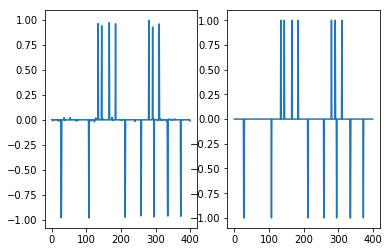

mse:  7.568277007216475e-05


In [5]:
plt.subplot(1, 2, 1)
plt.plot(coeffs)
plt.subplot(1, 2, 2)
plt.plot(x)
plt.show()
print('mse: ',np.sum((coeffs.reshape(x.shape)-x)**2)/len(x))

### Try SnP 500

In [4]:
import pandas as pd

In [5]:
def tracking_error(r_a, r_b):
    return np.std(r_a - r_b)

In [6]:
mydateparser = lambda x: pd.datetime.strptime(x, "%m/%d/%y")
sp500_all = pd.read_csv('sandp500/sp500_pct.csv', index_col='Date', parse_dates=['Date.1'], date_parser = mydateparser)



In [7]:
constituents_names = sp500_all.columns.tolist()
constituents_names = [x for x in constituents_names if x not in ['Date', 'Date.1', 'SP500']]
constituents = sp500_all[constituents_names]
sp500 = sp500_all['SP500']

In [12]:
N = 90

A = constituents.iloc[:N,:].values
y = sp500[:N].values
cutting_threshold = 1e-5
## solve the en problem
s = gelasticnetSover()

In [460]:
lam_1 = 55#0.01*np.linalg.norm((A.transpose()).dot(y),np.inf) 
lam_2 = 0
print('lambda_1:{}, lambda_2:{}'.format(lam_1, lam_2))
p = A.shape[1]
# Pmat = np.random.randn(p,p)
# Pmat=(Pmat + Pmat.T)/2
Pmat=np.ones((p,p))
# dvec = abs(np.random.random(p))
dvec = np.ones(p)
lowbo=0*np.ones(p)
upbo=1*np.ones(p)
coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=10, text='Off')
selection = np.array([x if x >cutting_threshold else 0 for x in coeffs])
selection = selection/sum(selection)
selection_ind = np.where(selection>0)[0]
print('number of selected stocks: {}'.format(len(selection_ind)))
A_ = A[:,selection_ind]
p_ = A_.shape[1]
Pmat_=np.ones((p_,p_))
# dvec = abs(np.random.random(p))
dvec_ = np.ones(p_)
lowbo_=0*np.ones(p_)
upbo_=1*np.ones(p_)
coeffs_=s.solve(A_,y,lam_1,lam_2,lowbo_,upbo_,dvec_, Pmat_,err_tol=1e-8, text_fr=10, text='Off')
coeffs_ = coeffs_/sum(coeffs_)
fund_index = A @ (selection)
fund_index_ = A_ @ (coeffs_)

print('sum coeffs:{}'.format(sum(coeffs)))

lambda_1:55, lambda_2:0
number of selected stocks: 89
sum coeffs:0.0029134196381298376


/anaconda3/envs/lle/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


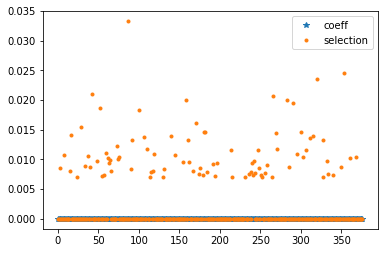

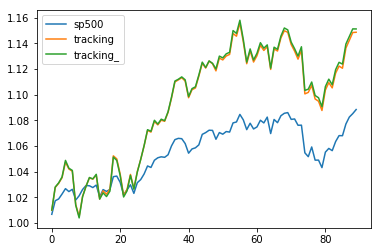

tracking error(monthly): 2.474%
tracking error_(yearly): 2.582%


In [461]:
plt.plot(coeffs, linewidth=0,marker="*")
plt.plot(selection.tolist(), linewidth=0,marker=".")
plt.legend(['coeff', 'selection'])
plt.show()

plt.plot(np.cumprod(1+y))
plt.plot(np.cumprod(1+fund_index))
plt.plot(np.cumprod(1+fund_index_))
plt.legend(['sp500', 'tracking', 'tracking_'])
plt.show()
print('tracking error(monthly): {:.3f}%'.format(np.sqrt(25)*100*tracking_error(y, fund_index)))
print('tracking error_(yearly): {:.3f}%'.format(np.sqrt(25)*100*tracking_error(y, fund_index_)))

In [53]:
from itertools import product

lam_1s = [1*i for i in range(200)]
lam_2s = [0.05*i for i in range(30)]
cutting_threshold = 1e-5
selections = []
tracking_errors = np.empty((len(lam_1s), len(lam_2s)))
selection_numbbers = np.empty((len(lam_1s), len(lam_2s)))
tot_it = len(lam_1s)*len(lam_2s)
counter = 1
i=0
j=0
# for lam_1, lam_2 in product(lam_1s, lam_2s):
for i, lam_1 in enumerate(lam_1s):
    for j, lam_2 in enumerate(lam_2s):
        p = A.shape[1]
        # Pmat = np.random.randn(p,p)
        # Pmat=(Pmat + Pmat.T)/2
        Pmat=np.ones((p,p))
        # dvec = abs(np.random.random(p))
        dvec = np.ones(p)
        lowbo=0*np.ones(p)
        upbo=1*np.ones(p)
        coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=10, text='Off')
        selection = np.array([x if x >cutting_threshold else 0 for x in coeffs])
        selection = selection/sum(selection)
        selection_ind = np.where(selection>0)[0]
        selections.append(selection)
        fund_index = A @ (selection)
        tracking_errors[i,j] = np.sqrt(252)*tracking_error(y, fund_index)
        selection_numbbers[i,j] = len(selection_ind)
        print('processing lam_1={}, and lam_2={} ({:.3f}% out of {}): number of selection: {}'.format(lam_1, lam_2, 100*counter/tot_it, tot_it, len(selection_ind)))
        counter += 1


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


processing lam_1=0, and lam_2=0.0 (0.017% out of 6000): number of selection: 377
processing lam_1=0, and lam_2=0.05 (0.033% out of 6000): number of selection: 377
processing lam_1=0, and lam_2=0.1 (0.050% out of 6000): number of selection: 376
processing lam_1=0, and lam_2=0.15000000000000002 (0.067% out of 6000): number of selection: 375
processing lam_1=0, and lam_2=0.2 (0.083% out of 6000): number of selection: 372
processing lam_1=0, and lam_2=0.25 (0.100% out of 6000): number of selection: 366
processing lam_1=0, and lam_2=0.30000000000000004 (0.117% out of 6000): number of selection: 351
processing lam_1=0, and lam_2=0.35000000000000003 (0.133% out of 6000): number of selection: 337
processing lam_1=0, and lam_2=0.4 (0.150% out of 6000): number of selection: 324
processing lam_1=0, and lam_2=0.45 (0.167% out of 6000): number of selection: 307
processing lam_1=0, and lam_2=0.5 (0.183% out of 6000): number of selection: 277
processing lam_1=0, and lam_2=0.55 (0.200% out of 6000): n

processing lam_1=3, and lam_2=0.45 (1.667% out of 6000): number of selection: 305
processing lam_1=3, and lam_2=0.5 (1.683% out of 6000): number of selection: 277
processing lam_1=3, and lam_2=0.55 (1.700% out of 6000): number of selection: 254
processing lam_1=3, and lam_2=0.6000000000000001 (1.717% out of 6000): number of selection: 219
processing lam_1=3, and lam_2=0.65 (1.733% out of 6000): number of selection: 188
processing lam_1=3, and lam_2=0.7000000000000001 (1.750% out of 6000): number of selection: 150
processing lam_1=3, and lam_2=0.75 (1.767% out of 6000): number of selection: 121
processing lam_1=3, and lam_2=0.8 (1.783% out of 6000): number of selection: 98
processing lam_1=3, and lam_2=0.8500000000000001 (1.800% out of 6000): number of selection: 76
processing lam_1=3, and lam_2=0.9 (1.817% out of 6000): number of selection: 60
processing lam_1=3, and lam_2=0.9500000000000001 (1.833% out of 6000): number of selection: 49
processing lam_1=3, and lam_2=1.0 (1.850% out of 

processing lam_1=6, and lam_2=1.4500000000000002 (3.500% out of 6000): number of selection: 3
processing lam_1=7, and lam_2=0.0 (3.517% out of 6000): number of selection: 377
processing lam_1=7, and lam_2=0.05 (3.533% out of 6000): number of selection: 377
processing lam_1=7, and lam_2=0.1 (3.550% out of 6000): number of selection: 375
processing lam_1=7, and lam_2=0.15000000000000002 (3.567% out of 6000): number of selection: 374
processing lam_1=7, and lam_2=0.2 (3.583% out of 6000): number of selection: 371
processing lam_1=7, and lam_2=0.25 (3.600% out of 6000): number of selection: 365
processing lam_1=7, and lam_2=0.30000000000000004 (3.617% out of 6000): number of selection: 349
processing lam_1=7, and lam_2=0.35000000000000003 (3.633% out of 6000): number of selection: 337
processing lam_1=7, and lam_2=0.4 (3.650% out of 6000): number of selection: 323
processing lam_1=7, and lam_2=0.45 (3.667% out of 6000): number of selection: 304
processing lam_1=7, and lam_2=0.5 (3.683% out

processing lam_1=10, and lam_2=0.2 (5.083% out of 6000): number of selection: 371
processing lam_1=10, and lam_2=0.25 (5.100% out of 6000): number of selection: 363
processing lam_1=10, and lam_2=0.30000000000000004 (5.117% out of 6000): number of selection: 348
processing lam_1=10, and lam_2=0.35000000000000003 (5.133% out of 6000): number of selection: 337
processing lam_1=10, and lam_2=0.4 (5.150% out of 6000): number of selection: 322
processing lam_1=10, and lam_2=0.45 (5.167% out of 6000): number of selection: 304
processing lam_1=10, and lam_2=0.5 (5.183% out of 6000): number of selection: 276
processing lam_1=10, and lam_2=0.55 (5.200% out of 6000): number of selection: 254
processing lam_1=10, and lam_2=0.6000000000000001 (5.217% out of 6000): number of selection: 216
processing lam_1=10, and lam_2=0.65 (5.233% out of 6000): number of selection: 184
processing lam_1=10, and lam_2=0.7000000000000001 (5.250% out of 6000): number of selection: 146
processing lam_1=10, and lam_2=0

processing lam_1=13, and lam_2=0.8500000000000001 (6.800% out of 6000): number of selection: 75
processing lam_1=13, and lam_2=0.9 (6.817% out of 6000): number of selection: 57
processing lam_1=13, and lam_2=0.9500000000000001 (6.833% out of 6000): number of selection: 47
processing lam_1=13, and lam_2=1.0 (6.850% out of 6000): number of selection: 38
processing lam_1=13, and lam_2=1.05 (6.867% out of 6000): number of selection: 30
processing lam_1=13, and lam_2=1.1 (6.883% out of 6000): number of selection: 23
processing lam_1=13, and lam_2=1.1500000000000001 (6.900% out of 6000): number of selection: 20
processing lam_1=13, and lam_2=1.2000000000000002 (6.917% out of 6000): number of selection: 11
processing lam_1=13, and lam_2=1.25 (6.933% out of 6000): number of selection: 11
processing lam_1=13, and lam_2=1.3 (6.950% out of 6000): number of selection: 8
processing lam_1=13, and lam_2=1.35 (6.967% out of 6000): number of selection: 6
processing lam_1=13, and lam_2=1.400000000000000

processing lam_1=16, and lam_2=1.2000000000000002 (8.417% out of 6000): number of selection: 11
processing lam_1=16, and lam_2=1.25 (8.433% out of 6000): number of selection: 11
processing lam_1=16, and lam_2=1.3 (8.450% out of 6000): number of selection: 8
processing lam_1=16, and lam_2=1.35 (8.467% out of 6000): number of selection: 6
processing lam_1=16, and lam_2=1.4000000000000001 (8.483% out of 6000): number of selection: 4
processing lam_1=16, and lam_2=1.4500000000000002 (8.500% out of 6000): number of selection: 3
processing lam_1=17, and lam_2=0.0 (8.517% out of 6000): number of selection: 372
processing lam_1=17, and lam_2=0.05 (8.533% out of 6000): number of selection: 377
processing lam_1=17, and lam_2=0.1 (8.550% out of 6000): number of selection: 375
processing lam_1=17, and lam_2=0.15000000000000002 (8.567% out of 6000): number of selection: 374
processing lam_1=17, and lam_2=0.2 (8.583% out of 6000): number of selection: 370
processing lam_1=17, and lam_2=0.25 (8.600% 

processing lam_1=20, and lam_2=0.6000000000000001 (10.217% out of 6000): number of selection: 210
processing lam_1=20, and lam_2=0.65 (10.233% out of 6000): number of selection: 181
processing lam_1=20, and lam_2=0.7000000000000001 (10.250% out of 6000): number of selection: 141
processing lam_1=20, and lam_2=0.75 (10.267% out of 6000): number of selection: 116
processing lam_1=20, and lam_2=0.8 (10.283% out of 6000): number of selection: 89
processing lam_1=20, and lam_2=0.8500000000000001 (10.300% out of 6000): number of selection: 74
processing lam_1=20, and lam_2=0.9 (10.317% out of 6000): number of selection: 56
processing lam_1=20, and lam_2=0.9500000000000001 (10.333% out of 6000): number of selection: 45
processing lam_1=20, and lam_2=1.0 (10.350% out of 6000): number of selection: 36
processing lam_1=20, and lam_2=1.05 (10.367% out of 6000): number of selection: 30
processing lam_1=20, and lam_2=1.1 (10.383% out of 6000): number of selection: 23
processing lam_1=20, and lam_2=

processing lam_1=23, and lam_2=1.35 (11.967% out of 6000): number of selection: 6
processing lam_1=23, and lam_2=1.4000000000000001 (11.983% out of 6000): number of selection: 4
processing lam_1=23, and lam_2=1.4500000000000002 (12.000% out of 6000): number of selection: 3
processing lam_1=24, and lam_2=0.0 (12.017% out of 6000): number of selection: 341
processing lam_1=24, and lam_2=0.05 (12.033% out of 6000): number of selection: 376
processing lam_1=24, and lam_2=0.1 (12.050% out of 6000): number of selection: 375
processing lam_1=24, and lam_2=0.15000000000000002 (12.067% out of 6000): number of selection: 374
processing lam_1=24, and lam_2=0.2 (12.083% out of 6000): number of selection: 370
processing lam_1=24, and lam_2=0.25 (12.100% out of 6000): number of selection: 359
processing lam_1=24, and lam_2=0.30000000000000004 (12.117% out of 6000): number of selection: 348
processing lam_1=24, and lam_2=0.35000000000000003 (12.133% out of 6000): number of selection: 334
processing l

processing lam_1=27, and lam_2=0.7000000000000001 (13.750% out of 6000): number of selection: 141
processing lam_1=27, and lam_2=0.75 (13.767% out of 6000): number of selection: 114
processing lam_1=27, and lam_2=0.8 (13.783% out of 6000): number of selection: 87
processing lam_1=27, and lam_2=0.8500000000000001 (13.800% out of 6000): number of selection: 70
processing lam_1=27, and lam_2=0.9 (13.817% out of 6000): number of selection: 55
processing lam_1=27, and lam_2=0.9500000000000001 (13.833% out of 6000): number of selection: 42
processing lam_1=27, and lam_2=1.0 (13.850% out of 6000): number of selection: 35
processing lam_1=27, and lam_2=1.05 (13.867% out of 6000): number of selection: 26
processing lam_1=27, and lam_2=1.1 (13.883% out of 6000): number of selection: 23
processing lam_1=27, and lam_2=1.1500000000000001 (13.900% out of 6000): number of selection: 18
processing lam_1=27, and lam_2=1.2000000000000002 (13.917% out of 6000): number of selection: 11
processing lam_1=27

processing lam_1=30, and lam_2=1.4500000000000002 (15.500% out of 6000): number of selection: 3
processing lam_1=31, and lam_2=0.0 (15.517% out of 6000): number of selection: 305
processing lam_1=31, and lam_2=0.05 (15.533% out of 6000): number of selection: 376
processing lam_1=31, and lam_2=0.1 (15.550% out of 6000): number of selection: 375
processing lam_1=31, and lam_2=0.15000000000000002 (15.567% out of 6000): number of selection: 374
processing lam_1=31, and lam_2=0.2 (15.583% out of 6000): number of selection: 369
processing lam_1=31, and lam_2=0.25 (15.600% out of 6000): number of selection: 358
processing lam_1=31, and lam_2=0.30000000000000004 (15.617% out of 6000): number of selection: 347
processing lam_1=31, and lam_2=0.35000000000000003 (15.633% out of 6000): number of selection: 334
processing lam_1=31, and lam_2=0.4 (15.650% out of 6000): number of selection: 317
processing lam_1=31, and lam_2=0.45 (15.667% out of 6000): number of selection: 294
processing lam_1=31, an

processing lam_1=34, and lam_2=0.75 (17.267% out of 6000): number of selection: 111
processing lam_1=34, and lam_2=0.8 (17.283% out of 6000): number of selection: 87
processing lam_1=34, and lam_2=0.8500000000000001 (17.300% out of 6000): number of selection: 68
processing lam_1=34, and lam_2=0.9 (17.317% out of 6000): number of selection: 55
processing lam_1=34, and lam_2=0.9500000000000001 (17.333% out of 6000): number of selection: 41
processing lam_1=34, and lam_2=1.0 (17.350% out of 6000): number of selection: 32
processing lam_1=34, and lam_2=1.05 (17.367% out of 6000): number of selection: 26
processing lam_1=34, and lam_2=1.1 (17.383% out of 6000): number of selection: 23
processing lam_1=34, and lam_2=1.1500000000000001 (17.400% out of 6000): number of selection: 15
processing lam_1=34, and lam_2=1.2000000000000002 (17.417% out of 6000): number of selection: 11
processing lam_1=34, and lam_2=1.25 (17.433% out of 6000): number of selection: 11
processing lam_1=34, and lam_2=1.3

processing lam_1=37, and lam_2=1.1 (18.883% out of 6000): number of selection: 23
processing lam_1=37, and lam_2=1.1500000000000001 (18.900% out of 6000): number of selection: 15
processing lam_1=37, and lam_2=1.2000000000000002 (18.917% out of 6000): number of selection: 11
processing lam_1=37, and lam_2=1.25 (18.933% out of 6000): number of selection: 11
processing lam_1=37, and lam_2=1.3 (18.950% out of 6000): number of selection: 7
processing lam_1=37, and lam_2=1.35 (18.967% out of 6000): number of selection: 6
processing lam_1=37, and lam_2=1.4000000000000001 (18.983% out of 6000): number of selection: 4
processing lam_1=37, and lam_2=1.4500000000000002 (19.000% out of 6000): number of selection: 3
processing lam_1=38, and lam_2=0.0 (19.017% out of 6000): number of selection: 247
processing lam_1=38, and lam_2=0.05 (19.033% out of 6000): number of selection: 376
processing lam_1=38, and lam_2=0.1 (19.050% out of 6000): number of selection: 375
processing lam_1=38, and lam_2=0.150

processing lam_1=41, and lam_2=0.30000000000000004 (20.617% out of 6000): number of selection: 343
processing lam_1=41, and lam_2=0.35000000000000003 (20.633% out of 6000): number of selection: 333
processing lam_1=41, and lam_2=0.4 (20.650% out of 6000): number of selection: 314
processing lam_1=41, and lam_2=0.45 (20.667% out of 6000): number of selection: 291
processing lam_1=41, and lam_2=0.5 (20.683% out of 6000): number of selection: 267
processing lam_1=41, and lam_2=0.55 (20.700% out of 6000): number of selection: 241
processing lam_1=41, and lam_2=0.6000000000000001 (20.717% out of 6000): number of selection: 196
processing lam_1=41, and lam_2=0.65 (20.733% out of 6000): number of selection: 165
processing lam_1=41, and lam_2=0.7000000000000001 (20.750% out of 6000): number of selection: 135
processing lam_1=41, and lam_2=0.75 (20.767% out of 6000): number of selection: 110
processing lam_1=41, and lam_2=0.8 (20.783% out of 6000): number of selection: 83
processing lam_1=41, a

processing lam_1=44, and lam_2=0.5 (22.183% out of 6000): number of selection: 266
processing lam_1=44, and lam_2=0.55 (22.200% out of 6000): number of selection: 240
processing lam_1=44, and lam_2=0.6000000000000001 (22.217% out of 6000): number of selection: 196
processing lam_1=44, and lam_2=0.65 (22.233% out of 6000): number of selection: 163
processing lam_1=44, and lam_2=0.7000000000000001 (22.250% out of 6000): number of selection: 134
processing lam_1=44, and lam_2=0.75 (22.267% out of 6000): number of selection: 110
processing lam_1=44, and lam_2=0.8 (22.283% out of 6000): number of selection: 82
processing lam_1=44, and lam_2=0.8500000000000001 (22.300% out of 6000): number of selection: 63
processing lam_1=44, and lam_2=0.9 (22.317% out of 6000): number of selection: 53
processing lam_1=44, and lam_2=0.9500000000000001 (22.333% out of 6000): number of selection: 41
processing lam_1=44, and lam_2=1.0 (22.350% out of 6000): number of selection: 32
processing lam_1=44, and lam_

processing lam_1=47, and lam_2=1.4000000000000001 (23.983% out of 6000): number of selection: 4
processing lam_1=47, and lam_2=1.4500000000000002 (24.000% out of 6000): number of selection: 3
processing lam_1=48, and lam_2=0.0 (24.017% out of 6000): number of selection: 143
processing lam_1=48, and lam_2=0.05 (24.033% out of 6000): number of selection: 375
processing lam_1=48, and lam_2=0.1 (24.050% out of 6000): number of selection: 375
processing lam_1=48, and lam_2=0.15000000000000002 (24.067% out of 6000): number of selection: 373
processing lam_1=48, and lam_2=0.2 (24.083% out of 6000): number of selection: 367
processing lam_1=48, and lam_2=0.25 (24.100% out of 6000): number of selection: 352
processing lam_1=48, and lam_2=0.30000000000000004 (24.117% out of 6000): number of selection: 342
processing lam_1=48, and lam_2=0.35000000000000003 (24.133% out of 6000): number of selection: 330
processing lam_1=48, and lam_2=0.4 (24.150% out of 6000): number of selection: 314
processing 

processing lam_1=51, and lam_2=0.55 (25.700% out of 6000): number of selection: 233
processing lam_1=51, and lam_2=0.6000000000000001 (25.717% out of 6000): number of selection: 192
processing lam_1=51, and lam_2=0.65 (25.733% out of 6000): number of selection: 160
processing lam_1=51, and lam_2=0.7000000000000001 (25.750% out of 6000): number of selection: 131
processing lam_1=51, and lam_2=0.75 (25.767% out of 6000): number of selection: 107
processing lam_1=51, and lam_2=0.8 (25.783% out of 6000): number of selection: 80
processing lam_1=51, and lam_2=0.8500000000000001 (25.800% out of 6000): number of selection: 62
processing lam_1=51, and lam_2=0.9 (25.817% out of 6000): number of selection: 53
processing lam_1=51, and lam_2=0.9500000000000001 (25.833% out of 6000): number of selection: 41
processing lam_1=51, and lam_2=1.0 (25.850% out of 6000): number of selection: 32
processing lam_1=51, and lam_2=1.05 (25.867% out of 6000): number of selection: 26
processing lam_1=51, and lam_

processing lam_1=54, and lam_2=1.25 (27.433% out of 6000): number of selection: 9
processing lam_1=54, and lam_2=1.3 (27.450% out of 6000): number of selection: 7
processing lam_1=54, and lam_2=1.35 (27.467% out of 6000): number of selection: 6
processing lam_1=54, and lam_2=1.4000000000000001 (27.483% out of 6000): number of selection: 4
processing lam_1=54, and lam_2=1.4500000000000002 (27.500% out of 6000): number of selection: 3
processing lam_1=55, and lam_2=0.0 (27.517% out of 6000): number of selection: 89
processing lam_1=55, and lam_2=0.05 (27.533% out of 6000): number of selection: 375
processing lam_1=55, and lam_2=0.1 (27.550% out of 6000): number of selection: 375
processing lam_1=55, and lam_2=0.15000000000000002 (27.567% out of 6000): number of selection: 373
processing lam_1=55, and lam_2=0.2 (27.583% out of 6000): number of selection: 367
processing lam_1=55, and lam_2=0.25 (27.600% out of 6000): number of selection: 351
processing lam_1=55, and lam_2=0.300000000000000

processing lam_1=58, and lam_2=0.4 (29.150% out of 6000): number of selection: 312
processing lam_1=58, and lam_2=0.45 (29.167% out of 6000): number of selection: 286
processing lam_1=58, and lam_2=0.5 (29.183% out of 6000): number of selection: 262
processing lam_1=58, and lam_2=0.55 (29.200% out of 6000): number of selection: 229
processing lam_1=58, and lam_2=0.6000000000000001 (29.217% out of 6000): number of selection: 190
processing lam_1=58, and lam_2=0.65 (29.233% out of 6000): number of selection: 157
processing lam_1=58, and lam_2=0.7000000000000001 (29.250% out of 6000): number of selection: 129
processing lam_1=58, and lam_2=0.75 (29.267% out of 6000): number of selection: 104
processing lam_1=58, and lam_2=0.8 (29.283% out of 6000): number of selection: 79
processing lam_1=58, and lam_2=0.8500000000000001 (29.300% out of 6000): number of selection: 61
processing lam_1=58, and lam_2=0.9 (29.317% out of 6000): number of selection: 52
processing lam_1=58, and lam_2=0.95000000

processing lam_1=61, and lam_2=1.0 (30.850% out of 6000): number of selection: 32
processing lam_1=61, and lam_2=1.05 (30.867% out of 6000): number of selection: 25
processing lam_1=61, and lam_2=1.1 (30.883% out of 6000): number of selection: 20
processing lam_1=61, and lam_2=1.1500000000000001 (30.900% out of 6000): number of selection: 13
processing lam_1=61, and lam_2=1.2000000000000002 (30.917% out of 6000): number of selection: 11
processing lam_1=61, and lam_2=1.25 (30.933% out of 6000): number of selection: 9
processing lam_1=61, and lam_2=1.3 (30.950% out of 6000): number of selection: 7
processing lam_1=61, and lam_2=1.35 (30.967% out of 6000): number of selection: 6
processing lam_1=61, and lam_2=1.4000000000000001 (30.983% out of 6000): number of selection: 4
processing lam_1=61, and lam_2=1.4500000000000002 (31.000% out of 6000): number of selection: 3
processing lam_1=62, and lam_2=0.0 (31.017% out of 6000): number of selection: 53
processing lam_1=62, and lam_2=0.05 (31.

processing lam_1=65, and lam_2=0.0 (32.517% out of 6000): number of selection: 45
processing lam_1=65, and lam_2=0.05 (32.533% out of 6000): number of selection: 375
processing lam_1=65, and lam_2=0.1 (32.550% out of 6000): number of selection: 374
processing lam_1=65, and lam_2=0.15000000000000002 (32.567% out of 6000): number of selection: 371
processing lam_1=65, and lam_2=0.2 (32.583% out of 6000): number of selection: 365
processing lam_1=65, and lam_2=0.25 (32.600% out of 6000): number of selection: 351
processing lam_1=65, and lam_2=0.30000000000000004 (32.617% out of 6000): number of selection: 337
processing lam_1=65, and lam_2=0.35000000000000003 (32.633% out of 6000): number of selection: 324
processing lam_1=65, and lam_2=0.4 (32.650% out of 6000): number of selection: 308
processing lam_1=65, and lam_2=0.45 (32.667% out of 6000): number of selection: 279
processing lam_1=65, and lam_2=0.5 (32.683% out of 6000): number of selection: 260
processing lam_1=65, and lam_2=0.55 (

processing lam_1=68, and lam_2=0.6000000000000001 (34.217% out of 6000): number of selection: 189
processing lam_1=68, and lam_2=0.65 (34.233% out of 6000): number of selection: 153
processing lam_1=68, and lam_2=0.7000000000000001 (34.250% out of 6000): number of selection: 126
processing lam_1=68, and lam_2=0.75 (34.267% out of 6000): number of selection: 100
processing lam_1=68, and lam_2=0.8 (34.283% out of 6000): number of selection: 77
processing lam_1=68, and lam_2=0.8500000000000001 (34.300% out of 6000): number of selection: 60
processing lam_1=68, and lam_2=0.9 (34.317% out of 6000): number of selection: 51
processing lam_1=68, and lam_2=0.9500000000000001 (34.333% out of 6000): number of selection: 38
processing lam_1=68, and lam_2=1.0 (34.350% out of 6000): number of selection: 31
processing lam_1=68, and lam_2=1.05 (34.367% out of 6000): number of selection: 25
processing lam_1=68, and lam_2=1.1 (34.383% out of 6000): number of selection: 20
processing lam_1=68, and lam_2=

processing lam_1=71, and lam_2=1.1500000000000001 (35.900% out of 6000): number of selection: 12
processing lam_1=71, and lam_2=1.2000000000000002 (35.917% out of 6000): number of selection: 11
processing lam_1=71, and lam_2=1.25 (35.933% out of 6000): number of selection: 8
processing lam_1=71, and lam_2=1.3 (35.950% out of 6000): number of selection: 6
processing lam_1=71, and lam_2=1.35 (35.967% out of 6000): number of selection: 6
processing lam_1=71, and lam_2=1.4000000000000001 (35.983% out of 6000): number of selection: 3
processing lam_1=71, and lam_2=1.4500000000000002 (36.000% out of 6000): number of selection: 3
processing lam_1=72, and lam_2=0.0 (36.017% out of 6000): number of selection: 25
processing lam_1=72, and lam_2=0.05 (36.033% out of 6000): number of selection: 374
processing lam_1=72, and lam_2=0.1 (36.050% out of 6000): number of selection: 374
processing lam_1=72, and lam_2=0.15000000000000002 (36.067% out of 6000): number of selection: 370
processing lam_1=72, 

processing lam_1=75, and lam_2=0.25 (37.600% out of 6000): number of selection: 348
processing lam_1=75, and lam_2=0.30000000000000004 (37.617% out of 6000): number of selection: 335
processing lam_1=75, and lam_2=0.35000000000000003 (37.633% out of 6000): number of selection: 322
processing lam_1=75, and lam_2=0.4 (37.650% out of 6000): number of selection: 304
processing lam_1=75, and lam_2=0.45 (37.667% out of 6000): number of selection: 276
processing lam_1=75, and lam_2=0.5 (37.683% out of 6000): number of selection: 254
processing lam_1=75, and lam_2=0.55 (37.700% out of 6000): number of selection: 216
processing lam_1=75, and lam_2=0.6000000000000001 (37.717% out of 6000): number of selection: 185
processing lam_1=75, and lam_2=0.65 (37.733% out of 6000): number of selection: 148
processing lam_1=75, and lam_2=0.7000000000000001 (37.750% out of 6000): number of selection: 121
processing lam_1=75, and lam_2=0.75 (37.767% out of 6000): number of selection: 98
processing lam_1=75, 

processing lam_1=78, and lam_2=0.5 (39.183% out of 6000): number of selection: 254
processing lam_1=78, and lam_2=0.55 (39.200% out of 6000): number of selection: 216
processing lam_1=78, and lam_2=0.6000000000000001 (39.217% out of 6000): number of selection: 184
processing lam_1=78, and lam_2=0.65 (39.233% out of 6000): number of selection: 147
processing lam_1=78, and lam_2=0.7000000000000001 (39.250% out of 6000): number of selection: 120
processing lam_1=78, and lam_2=0.75 (39.267% out of 6000): number of selection: 94
processing lam_1=78, and lam_2=0.8 (39.283% out of 6000): number of selection: 75
processing lam_1=78, and lam_2=0.8500000000000001 (39.300% out of 6000): number of selection: 57
processing lam_1=78, and lam_2=0.9 (39.317% out of 6000): number of selection: 48
processing lam_1=78, and lam_2=0.9500000000000001 (39.333% out of 6000): number of selection: 38
processing lam_1=78, and lam_2=1.0 (39.350% out of 6000): number of selection: 30
processing lam_1=78, and lam_2

processing lam_1=81, and lam_2=0.9500000000000001 (40.833% out of 6000): number of selection: 38
processing lam_1=81, and lam_2=1.0 (40.850% out of 6000): number of selection: 30
processing lam_1=81, and lam_2=1.05 (40.867% out of 6000): number of selection: 23
processing lam_1=81, and lam_2=1.1 (40.883% out of 6000): number of selection: 20
processing lam_1=81, and lam_2=1.1500000000000001 (40.900% out of 6000): number of selection: 11
processing lam_1=81, and lam_2=1.2000000000000002 (40.917% out of 6000): number of selection: 11
processing lam_1=81, and lam_2=1.25 (40.933% out of 6000): number of selection: 8
processing lam_1=81, and lam_2=1.3 (40.950% out of 6000): number of selection: 6
processing lam_1=81, and lam_2=1.35 (40.967% out of 6000): number of selection: 6
processing lam_1=81, and lam_2=1.4000000000000001 (40.983% out of 6000): number of selection: 3
processing lam_1=81, and lam_2=1.4500000000000002 (41.000% out of 6000): number of selection: 3
processing lam_1=82, and 

processing lam_1=85, and lam_2=0.25 (42.600% out of 6000): number of selection: 348
processing lam_1=85, and lam_2=0.30000000000000004 (42.617% out of 6000): number of selection: 334
processing lam_1=85, and lam_2=0.35000000000000003 (42.633% out of 6000): number of selection: 318
processing lam_1=85, and lam_2=0.4 (42.650% out of 6000): number of selection: 299
processing lam_1=85, and lam_2=0.45 (42.667% out of 6000): number of selection: 273
processing lam_1=85, and lam_2=0.5 (42.683% out of 6000): number of selection: 248
processing lam_1=85, and lam_2=0.55 (42.700% out of 6000): number of selection: 210
processing lam_1=85, and lam_2=0.6000000000000001 (42.717% out of 6000): number of selection: 181
processing lam_1=85, and lam_2=0.65 (42.733% out of 6000): number of selection: 145
processing lam_1=85, and lam_2=0.7000000000000001 (42.750% out of 6000): number of selection: 119
processing lam_1=85, and lam_2=0.75 (42.767% out of 6000): number of selection: 91
processing lam_1=85, 

processing lam_1=88, and lam_2=1.05 (44.367% out of 6000): number of selection: 23
processing lam_1=88, and lam_2=1.1 (44.383% out of 6000): number of selection: 19
processing lam_1=88, and lam_2=1.1500000000000001 (44.400% out of 6000): number of selection: 11
processing lam_1=88, and lam_2=1.2000000000000002 (44.417% out of 6000): number of selection: 11
processing lam_1=88, and lam_2=1.25 (44.433% out of 6000): number of selection: 8
processing lam_1=88, and lam_2=1.3 (44.450% out of 6000): number of selection: 6
processing lam_1=88, and lam_2=1.35 (44.467% out of 6000): number of selection: 4
processing lam_1=88, and lam_2=1.4000000000000001 (44.483% out of 6000): number of selection: 3
processing lam_1=88, and lam_2=1.4500000000000002 (44.500% out of 6000): number of selection: 3
processing lam_1=89, and lam_2=0.0 (44.517% out of 6000): number of selection: 10
processing lam_1=89, and lam_2=0.05 (44.533% out of 6000): number of selection: 370
processing lam_1=89, and lam_2=0.1 (44

processing lam_1=92, and lam_2=0.25 (46.100% out of 6000): number of selection: 345
processing lam_1=92, and lam_2=0.30000000000000004 (46.117% out of 6000): number of selection: 334
processing lam_1=92, and lam_2=0.35000000000000003 (46.133% out of 6000): number of selection: 317
processing lam_1=92, and lam_2=0.4 (46.150% out of 6000): number of selection: 295
processing lam_1=92, and lam_2=0.45 (46.167% out of 6000): number of selection: 270
processing lam_1=92, and lam_2=0.5 (46.183% out of 6000): number of selection: 246
processing lam_1=92, and lam_2=0.55 (46.200% out of 6000): number of selection: 205
processing lam_1=92, and lam_2=0.6000000000000001 (46.217% out of 6000): number of selection: 178
processing lam_1=92, and lam_2=0.65 (46.233% out of 6000): number of selection: 141
processing lam_1=92, and lam_2=0.7000000000000001 (46.250% out of 6000): number of selection: 115
processing lam_1=92, and lam_2=0.75 (46.267% out of 6000): number of selection: 87
processing lam_1=92, 

processing lam_1=95, and lam_2=0.9500000000000001 (47.833% out of 6000): number of selection: 35
processing lam_1=95, and lam_2=1.0 (47.850% out of 6000): number of selection: 28
processing lam_1=95, and lam_2=1.05 (47.867% out of 6000): number of selection: 23
processing lam_1=95, and lam_2=1.1 (47.883% out of 6000): number of selection: 19
processing lam_1=95, and lam_2=1.1500000000000001 (47.900% out of 6000): number of selection: 11
processing lam_1=95, and lam_2=1.2000000000000002 (47.917% out of 6000): number of selection: 11
processing lam_1=95, and lam_2=1.25 (47.933% out of 6000): number of selection: 7
processing lam_1=95, and lam_2=1.3 (47.950% out of 6000): number of selection: 6
processing lam_1=95, and lam_2=1.35 (47.967% out of 6000): number of selection: 4
processing lam_1=95, and lam_2=1.4000000000000001 (47.983% out of 6000): number of selection: 3
processing lam_1=95, and lam_2=1.4500000000000002 (48.000% out of 6000): number of selection: 3
processing lam_1=96, and 

processing lam_1=99, and lam_2=0.30000000000000004 (49.617% out of 6000): number of selection: 333
processing lam_1=99, and lam_2=0.35000000000000003 (49.633% out of 6000): number of selection: 314
processing lam_1=99, and lam_2=0.4 (49.650% out of 6000): number of selection: 291
processing lam_1=99, and lam_2=0.45 (49.667% out of 6000): number of selection: 268
processing lam_1=99, and lam_2=0.5 (49.683% out of 6000): number of selection: 241
processing lam_1=99, and lam_2=0.55 (49.700% out of 6000): number of selection: 199
processing lam_1=99, and lam_2=0.6000000000000001 (49.717% out of 6000): number of selection: 172
processing lam_1=99, and lam_2=0.65 (49.733% out of 6000): number of selection: 139
processing lam_1=99, and lam_2=0.7000000000000001 (49.750% out of 6000): number of selection: 111
processing lam_1=99, and lam_2=0.75 (49.767% out of 6000): number of selection: 87
processing lam_1=99, and lam_2=0.8 (49.783% out of 6000): number of selection: 68
processing lam_1=99, an

processing lam_1=102, and lam_2=1.0 (51.350% out of 6000): number of selection: 26
processing lam_1=102, and lam_2=1.05 (51.367% out of 6000): number of selection: 23
processing lam_1=102, and lam_2=1.1 (51.383% out of 6000): number of selection: 15
processing lam_1=102, and lam_2=1.1500000000000001 (51.400% out of 6000): number of selection: 11
processing lam_1=102, and lam_2=1.2000000000000002 (51.417% out of 6000): number of selection: 11
processing lam_1=102, and lam_2=1.25 (51.433% out of 6000): number of selection: 7
processing lam_1=102, and lam_2=1.3 (51.450% out of 6000): number of selection: 6
processing lam_1=102, and lam_2=1.35 (51.467% out of 6000): number of selection: 4
processing lam_1=102, and lam_2=1.4000000000000001 (51.483% out of 6000): number of selection: 3
processing lam_1=102, and lam_2=1.4500000000000002 (51.500% out of 6000): number of selection: 3
processing lam_1=103, and lam_2=0.0 (51.517% out of 6000): number of selection: 2
processing lam_1=103, and lam_

processing lam_1=106, and lam_2=0.30000000000000004 (53.117% out of 6000): number of selection: 327
processing lam_1=106, and lam_2=0.35000000000000003 (53.133% out of 6000): number of selection: 314
processing lam_1=106, and lam_2=0.4 (53.150% out of 6000): number of selection: 291
processing lam_1=106, and lam_2=0.45 (53.167% out of 6000): number of selection: 266
processing lam_1=106, and lam_2=0.5 (53.183% out of 6000): number of selection: 240
processing lam_1=106, and lam_2=0.55 (53.200% out of 6000): number of selection: 196
processing lam_1=106, and lam_2=0.6000000000000001 (53.217% out of 6000): number of selection: 165
processing lam_1=106, and lam_2=0.65 (53.233% out of 6000): number of selection: 135
processing lam_1=106, and lam_2=0.7000000000000001 (53.250% out of 6000): number of selection: 110
processing lam_1=106, and lam_2=0.75 (53.267% out of 6000): number of selection: 84
processing lam_1=106, and lam_2=0.8 (53.283% out of 6000): number of selection: 65
processing l

processing lam_1=109, and lam_2=0.8 (54.783% out of 6000): number of selection: 63
processing lam_1=109, and lam_2=0.8500000000000001 (54.800% out of 6000): number of selection: 53
processing lam_1=109, and lam_2=0.9 (54.817% out of 6000): number of selection: 41
processing lam_1=109, and lam_2=0.9500000000000001 (54.833% out of 6000): number of selection: 32
processing lam_1=109, and lam_2=1.0 (54.850% out of 6000): number of selection: 26
processing lam_1=109, and lam_2=1.05 (54.867% out of 6000): number of selection: 23
processing lam_1=109, and lam_2=1.1 (54.883% out of 6000): number of selection: 15
processing lam_1=109, and lam_2=1.1500000000000001 (54.900% out of 6000): number of selection: 11
processing lam_1=109, and lam_2=1.2000000000000002 (54.917% out of 6000): number of selection: 11
processing lam_1=109, and lam_2=1.25 (54.933% out of 6000): number of selection: 7
processing lam_1=109, and lam_2=1.3 (54.950% out of 6000): number of selection: 6
processing lam_1=109, and l

processing lam_1=113, and lam_2=0.2 (56.583% out of 6000): number of selection: 348
processing lam_1=113, and lam_2=0.25 (56.600% out of 6000): number of selection: 337
processing lam_1=113, and lam_2=0.30000000000000004 (56.617% out of 6000): number of selection: 325
processing lam_1=113, and lam_2=0.35000000000000003 (56.633% out of 6000): number of selection: 312
processing lam_1=113, and lam_2=0.4 (56.650% out of 6000): number of selection: 286
processing lam_1=113, and lam_2=0.45 (56.667% out of 6000): number of selection: 263
processing lam_1=113, and lam_2=0.5 (56.683% out of 6000): number of selection: 233
processing lam_1=113, and lam_2=0.55 (56.700% out of 6000): number of selection: 192
processing lam_1=113, and lam_2=0.6000000000000001 (56.717% out of 6000): number of selection: 160
processing lam_1=113, and lam_2=0.65 (56.733% out of 6000): number of selection: 131
processing lam_1=113, and lam_2=0.7000000000000001 (56.750% out of 6000): number of selection: 108
processing

processing lam_1=116, and lam_2=0.6000000000000001 (58.217% out of 6000): number of selection: 159
processing lam_1=116, and lam_2=0.65 (58.233% out of 6000): number of selection: 130
processing lam_1=116, and lam_2=0.7000000000000001 (58.250% out of 6000): number of selection: 107
processing lam_1=116, and lam_2=0.75 (58.267% out of 6000): number of selection: 80
processing lam_1=116, and lam_2=0.8 (58.283% out of 6000): number of selection: 62
processing lam_1=116, and lam_2=0.8500000000000001 (58.300% out of 6000): number of selection: 53
processing lam_1=116, and lam_2=0.9 (58.317% out of 6000): number of selection: 41
processing lam_1=116, and lam_2=0.9500000000000001 (58.333% out of 6000): number of selection: 32
processing lam_1=116, and lam_2=1.0 (58.350% out of 6000): number of selection: 26
processing lam_1=116, and lam_2=1.05 (58.367% out of 6000): number of selection: 23
processing lam_1=116, and lam_2=1.1 (58.383% out of 6000): number of selection: 15
processing lam_1=116,

processing lam_1=119, and lam_2=1.05 (59.867% out of 6000): number of selection: 21
processing lam_1=119, and lam_2=1.1 (59.883% out of 6000): number of selection: 15
processing lam_1=119, and lam_2=1.1500000000000001 (59.900% out of 6000): number of selection: 11
processing lam_1=119, and lam_2=1.2000000000000002 (59.917% out of 6000): number of selection: 10
processing lam_1=119, and lam_2=1.25 (59.933% out of 6000): number of selection: 7
processing lam_1=119, and lam_2=1.3 (59.950% out of 6000): number of selection: 6
processing lam_1=119, and lam_2=1.35 (59.967% out of 6000): number of selection: 4
processing lam_1=119, and lam_2=1.4000000000000001 (59.983% out of 6000): number of selection: 3
processing lam_1=119, and lam_2=1.4500000000000002 (60.000% out of 6000): number of selection: 2
processing lam_1=120, and lam_2=0.0 (60.017% out of 6000): number of selection: 1
processing lam_1=120, and lam_2=0.05 (60.033% out of 6000): number of selection: 348
processing lam_1=120, and la

/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


processing lam_1=122, and lam_2=0.5 (61.183% out of 6000): number of selection: 227
processing lam_1=122, and lam_2=0.55 (61.200% out of 6000): number of selection: 190
processing lam_1=122, and lam_2=0.6000000000000001 (61.217% out of 6000): number of selection: 157
processing lam_1=122, and lam_2=0.65 (61.233% out of 6000): number of selection: 128
processing lam_1=122, and lam_2=0.7000000000000001 (61.250% out of 6000): number of selection: 103
processing lam_1=122, and lam_2=0.75 (61.267% out of 6000): number of selection: 79
processing lam_1=122, and lam_2=0.8 (61.283% out of 6000): number of selection: 61
processing lam_1=122, and lam_2=0.8500000000000001 (61.300% out of 6000): number of selection: 53
processing lam_1=122, and lam_2=0.9 (61.317% out of 6000): number of selection: 40
processing lam_1=122, and lam_2=0.9500000000000001 (61.333% out of 6000): number of selection: 32
processing lam_1=122, and lam_2=1.0 (61.350% out of 6000): number of selection: 26
processing lam_1=12

processing lam_1=125, and lam_2=0.9 (62.817% out of 6000): number of selection: 38
processing lam_1=125, and lam_2=0.9500000000000001 (62.833% out of 6000): number of selection: 32
processing lam_1=125, and lam_2=1.0 (62.850% out of 6000): number of selection: 25
processing lam_1=125, and lam_2=1.05 (62.867% out of 6000): number of selection: 21
processing lam_1=125, and lam_2=1.1 (62.883% out of 6000): number of selection: 14
processing lam_1=125, and lam_2=1.1500000000000001 (62.900% out of 6000): number of selection: 11
processing lam_1=125, and lam_2=1.2000000000000002 (62.917% out of 6000): number of selection: 9
processing lam_1=125, and lam_2=1.25 (62.933% out of 6000): number of selection: 7
processing lam_1=125, and lam_2=1.3 (62.950% out of 6000): number of selection: 6
processing lam_1=125, and lam_2=1.35 (62.967% out of 6000): number of selection: 4
processing lam_1=125, and lam_2=1.4000000000000001 (62.983% out of 6000): number of selection: 3
processing lam_1=125, and lam

processing lam_1=128, and lam_2=1.35 (64.467% out of 6000): number of selection: 4
processing lam_1=128, and lam_2=1.4000000000000001 (64.483% out of 6000): number of selection: 3
processing lam_1=128, and lam_2=1.4500000000000002 (64.500% out of 6000): number of selection: 2
processing lam_1=129, and lam_2=0.0 (64.517% out of 6000): number of selection: 0
processing lam_1=129, and lam_2=0.05 (64.533% out of 6000): number of selection: 335
processing lam_1=129, and lam_2=0.1 (64.550% out of 6000): number of selection: 352
processing lam_1=129, and lam_2=0.15000000000000002 (64.567% out of 6000): number of selection: 351
processing lam_1=129, and lam_2=0.2 (64.583% out of 6000): number of selection: 344
processing lam_1=129, and lam_2=0.25 (64.600% out of 6000): number of selection: 334
processing lam_1=129, and lam_2=0.30000000000000004 (64.617% out of 6000): number of selection: 318
processing lam_1=129, and lam_2=0.35000000000000003 (64.633% out of 6000): number of selection: 303
pro

processing lam_1=132, and lam_2=0.0 (66.017% out of 6000): number of selection: 0
processing lam_1=132, and lam_2=0.05 (66.033% out of 6000): number of selection: 334
processing lam_1=132, and lam_2=0.1 (66.050% out of 6000): number of selection: 351
processing lam_1=132, and lam_2=0.15000000000000002 (66.067% out of 6000): number of selection: 350
processing lam_1=132, and lam_2=0.2 (66.083% out of 6000): number of selection: 342
processing lam_1=132, and lam_2=0.25 (66.100% out of 6000): number of selection: 334
processing lam_1=132, and lam_2=0.30000000000000004 (66.117% out of 6000): number of selection: 318
processing lam_1=132, and lam_2=0.35000000000000003 (66.133% out of 6000): number of selection: 300
processing lam_1=132, and lam_2=0.4 (66.150% out of 6000): number of selection: 275
processing lam_1=132, and lam_2=0.45 (66.167% out of 6000): number of selection: 254
processing lam_1=132, and lam_2=0.5 (66.183% out of 6000): number of selection: 216
processing lam_1=132, and l

processing lam_1=135, and lam_2=0.8 (67.783% out of 6000): number of selection: 60
processing lam_1=135, and lam_2=0.8500000000000001 (67.800% out of 6000): number of selection: 51
processing lam_1=135, and lam_2=0.9 (67.817% out of 6000): number of selection: 38
processing lam_1=135, and lam_2=0.9500000000000001 (67.833% out of 6000): number of selection: 30
processing lam_1=135, and lam_2=1.0 (67.850% out of 6000): number of selection: 25
processing lam_1=135, and lam_2=1.05 (67.867% out of 6000): number of selection: 20
processing lam_1=135, and lam_2=1.1 (67.883% out of 6000): number of selection: 13
processing lam_1=135, and lam_2=1.1500000000000001 (67.900% out of 6000): number of selection: 11
processing lam_1=135, and lam_2=1.2000000000000002 (67.917% out of 6000): number of selection: 8
processing lam_1=135, and lam_2=1.25 (67.933% out of 6000): number of selection: 7
processing lam_1=135, and lam_2=1.3 (67.950% out of 6000): number of selection: 6
processing lam_1=135, and la

processing lam_1=138, and lam_2=1.4500000000000002 (69.500% out of 6000): number of selection: 2
processing lam_1=139, and lam_2=0.0 (69.517% out of 6000): number of selection: 0
processing lam_1=139, and lam_2=0.05 (69.533% out of 6000): number of selection: 324
processing lam_1=139, and lam_2=0.1 (69.550% out of 6000): number of selection: 348
processing lam_1=139, and lam_2=0.15000000000000002 (69.567% out of 6000): number of selection: 348
processing lam_1=139, and lam_2=0.2 (69.583% out of 6000): number of selection: 339
processing lam_1=139, and lam_2=0.25 (69.600% out of 6000): number of selection: 333
processing lam_1=139, and lam_2=0.30000000000000004 (69.617% out of 6000): number of selection: 316
processing lam_1=139, and lam_2=0.35000000000000003 (69.633% out of 6000): number of selection: 295
processing lam_1=139, and lam_2=0.4 (69.650% out of 6000): number of selection: 272
processing lam_1=139, and lam_2=0.45 (69.667% out of 6000): number of selection: 248
processing lam

processing lam_1=142, and lam_2=0.6000000000000001 (71.217% out of 6000): number of selection: 145
processing lam_1=142, and lam_2=0.65 (71.233% out of 6000): number of selection: 119
processing lam_1=142, and lam_2=0.7000000000000001 (71.250% out of 6000): number of selection: 91
processing lam_1=142, and lam_2=0.75 (71.267% out of 6000): number of selection: 75
processing lam_1=142, and lam_2=0.8 (71.283% out of 6000): number of selection: 57
processing lam_1=142, and lam_2=0.8500000000000001 (71.300% out of 6000): number of selection: 48
processing lam_1=142, and lam_2=0.9 (71.317% out of 6000): number of selection: 38
processing lam_1=142, and lam_2=0.9500000000000001 (71.333% out of 6000): number of selection: 30
processing lam_1=142, and lam_2=1.0 (71.350% out of 6000): number of selection: 24
processing lam_1=142, and lam_2=1.05 (71.367% out of 6000): number of selection: 20
processing lam_1=142, and lam_2=1.1 (71.383% out of 6000): number of selection: 12
processing lam_1=142, 

processing lam_1=145, and lam_2=1.2000000000000002 (72.917% out of 6000): number of selection: 8
processing lam_1=145, and lam_2=1.25 (72.933% out of 6000): number of selection: 6
processing lam_1=145, and lam_2=1.3 (72.950% out of 6000): number of selection: 6
processing lam_1=145, and lam_2=1.35 (72.967% out of 6000): number of selection: 3
processing lam_1=145, and lam_2=1.4000000000000001 (72.983% out of 6000): number of selection: 3
processing lam_1=145, and lam_2=1.4500000000000002 (73.000% out of 6000): number of selection: 2
processing lam_1=146, and lam_2=0.0 (73.017% out of 6000): number of selection: 0
processing lam_1=146, and lam_2=0.05 (73.033% out of 6000): number of selection: 314
processing lam_1=146, and lam_2=0.1 (73.050% out of 6000): number of selection: 345
processing lam_1=146, and lam_2=0.15000000000000002 (73.067% out of 6000): number of selection: 345
processing lam_1=146, and lam_2=0.2 (73.083% out of 6000): number of selection: 337
processing lam_1=146, and 

processing lam_1=149, and lam_2=0.30000000000000004 (74.617% out of 6000): number of selection: 314
processing lam_1=149, and lam_2=0.35000000000000003 (74.633% out of 6000): number of selection: 291
processing lam_1=149, and lam_2=0.4 (74.650% out of 6000): number of selection: 268
processing lam_1=149, and lam_2=0.45 (74.667% out of 6000): number of selection: 244
processing lam_1=149, and lam_2=0.5 (74.683% out of 6000): number of selection: 203
processing lam_1=149, and lam_2=0.55 (74.700% out of 6000): number of selection: 178
processing lam_1=149, and lam_2=0.6000000000000001 (74.717% out of 6000): number of selection: 141
processing lam_1=149, and lam_2=0.65 (74.733% out of 6000): number of selection: 116
processing lam_1=149, and lam_2=0.7000000000000001 (74.750% out of 6000): number of selection: 89
processing lam_1=149, and lam_2=0.75 (74.767% out of 6000): number of selection: 74
processing lam_1=149, and lam_2=0.8 (74.783% out of 6000): number of selection: 56
processing la

processing lam_1=152, and lam_2=1.0 (76.350% out of 6000): number of selection: 23
processing lam_1=152, and lam_2=1.05 (76.367% out of 6000): number of selection: 19
processing lam_1=152, and lam_2=1.1 (76.383% out of 6000): number of selection: 11
processing lam_1=152, and lam_2=1.1500000000000001 (76.400% out of 6000): number of selection: 11
processing lam_1=152, and lam_2=1.2000000000000002 (76.417% out of 6000): number of selection: 8
processing lam_1=152, and lam_2=1.25 (76.433% out of 6000): number of selection: 6
processing lam_1=152, and lam_2=1.3 (76.450% out of 6000): number of selection: 4
processing lam_1=152, and lam_2=1.35 (76.467% out of 6000): number of selection: 3
processing lam_1=152, and lam_2=1.4000000000000001 (76.483% out of 6000): number of selection: 3
processing lam_1=152, and lam_2=1.4500000000000002 (76.500% out of 6000): number of selection: 2
processing lam_1=153, and lam_2=0.0 (76.517% out of 6000): number of selection: 0
processing lam_1=153, and lam_2

processing lam_1=156, and lam_2=0.1 (78.050% out of 6000): number of selection: 337
processing lam_1=156, and lam_2=0.15000000000000002 (78.067% out of 6000): number of selection: 338
processing lam_1=156, and lam_2=0.2 (78.083% out of 6000): number of selection: 334
processing lam_1=156, and lam_2=0.25 (78.100% out of 6000): number of selection: 323
processing lam_1=156, and lam_2=0.30000000000000004 (78.117% out of 6000): number of selection: 311
processing lam_1=156, and lam_2=0.35000000000000003 (78.133% out of 6000): number of selection: 287
processing lam_1=156, and lam_2=0.4 (78.150% out of 6000): number of selection: 266
processing lam_1=156, and lam_2=0.45 (78.167% out of 6000): number of selection: 240
processing lam_1=156, and lam_2=0.5 (78.183% out of 6000): number of selection: 197
processing lam_1=156, and lam_2=0.55 (78.200% out of 6000): number of selection: 171
processing lam_1=156, and lam_2=0.6000000000000001 (78.217% out of 6000): number of selection: 139
processing

processing lam_1=159, and lam_2=0.7000000000000001 (79.750% out of 6000): number of selection: 87
processing lam_1=159, and lam_2=0.75 (79.767% out of 6000): number of selection: 68
processing lam_1=159, and lam_2=0.8 (79.783% out of 6000): number of selection: 55
processing lam_1=159, and lam_2=0.8500000000000001 (79.800% out of 6000): number of selection: 42
processing lam_1=159, and lam_2=0.9 (79.817% out of 6000): number of selection: 35
processing lam_1=159, and lam_2=0.9500000000000001 (79.833% out of 6000): number of selection: 27
processing lam_1=159, and lam_2=1.0 (79.850% out of 6000): number of selection: 23
processing lam_1=159, and lam_2=1.05 (79.867% out of 6000): number of selection: 19
processing lam_1=159, and lam_2=1.1 (79.883% out of 6000): number of selection: 11
processing lam_1=159, and lam_2=1.1500000000000001 (79.900% out of 6000): number of selection: 11
processing lam_1=159, and lam_2=1.2000000000000002 (79.917% out of 6000): number of selection: 7
processing 

processing lam_1=162, and lam_2=1.35 (81.467% out of 6000): number of selection: 3
processing lam_1=162, and lam_2=1.4000000000000001 (81.483% out of 6000): number of selection: 3
processing lam_1=162, and lam_2=1.4500000000000002 (81.500% out of 6000): number of selection: 2
processing lam_1=163, and lam_2=0.0 (81.517% out of 6000): number of selection: 0
processing lam_1=163, and lam_2=0.05 (81.533% out of 6000): number of selection: 268
processing lam_1=163, and lam_2=0.1 (81.550% out of 6000): number of selection: 334
processing lam_1=163, and lam_2=0.15000000000000002 (81.567% out of 6000): number of selection: 335
processing lam_1=163, and lam_2=0.2 (81.583% out of 6000): number of selection: 333
processing lam_1=163, and lam_2=0.25 (81.600% out of 6000): number of selection: 318
processing lam_1=163, and lam_2=0.30000000000000004 (81.617% out of 6000): number of selection: 304
processing lam_1=163, and lam_2=0.35000000000000003 (81.633% out of 6000): number of selection: 280
pro

processing lam_1=166, and lam_2=0.55 (83.200% out of 6000): number of selection: 160
processing lam_1=166, and lam_2=0.6000000000000001 (83.217% out of 6000): number of selection: 132
processing lam_1=166, and lam_2=0.65 (83.233% out of 6000): number of selection: 110
processing lam_1=166, and lam_2=0.7000000000000001 (83.250% out of 6000): number of selection: 83
processing lam_1=166, and lam_2=0.75 (83.267% out of 6000): number of selection: 65
processing lam_1=166, and lam_2=0.8 (83.283% out of 6000): number of selection: 53
processing lam_1=166, and lam_2=0.8500000000000001 (83.300% out of 6000): number of selection: 41
processing lam_1=166, and lam_2=0.9 (83.317% out of 6000): number of selection: 32
processing lam_1=166, and lam_2=0.9500000000000001 (83.333% out of 6000): number of selection: 26
processing lam_1=166, and lam_2=1.0 (83.350% out of 6000): number of selection: 23
processing lam_1=166, and lam_2=1.05 (83.367% out of 6000): number of selection: 15
processing lam_1=166

processing lam_1=169, and lam_2=1.1500000000000001 (84.900% out of 6000): number of selection: 11
processing lam_1=169, and lam_2=1.2000000000000002 (84.917% out of 6000): number of selection: 7
processing lam_1=169, and lam_2=1.25 (84.933% out of 6000): number of selection: 6
processing lam_1=169, and lam_2=1.3 (84.950% out of 6000): number of selection: 4
processing lam_1=169, and lam_2=1.35 (84.967% out of 6000): number of selection: 3
processing lam_1=169, and lam_2=1.4000000000000001 (84.983% out of 6000): number of selection: 3
processing lam_1=169, and lam_2=1.4500000000000002 (85.000% out of 6000): number of selection: 2
processing lam_1=170, and lam_2=0.0 (85.017% out of 6000): number of selection: 0
processing lam_1=170, and lam_2=0.05 (85.033% out of 6000): number of selection: 248
processing lam_1=170, and lam_2=0.1 (85.050% out of 6000): number of selection: 326
processing lam_1=170, and lam_2=0.15000000000000002 (85.067% out of 6000): number of selection: 334
processing l

processing lam_1=173, and lam_2=0.25 (86.600% out of 6000): number of selection: 314
processing lam_1=173, and lam_2=0.30000000000000004 (86.617% out of 6000): number of selection: 298
processing lam_1=173, and lam_2=0.35000000000000003 (86.633% out of 6000): number of selection: 276
processing lam_1=173, and lam_2=0.4 (86.650% out of 6000): number of selection: 254
processing lam_1=173, and lam_2=0.45 (86.667% out of 6000): number of selection: 224
processing lam_1=173, and lam_2=0.5 (86.683% out of 6000): number of selection: 190
processing lam_1=173, and lam_2=0.55 (86.700% out of 6000): number of selection: 157
processing lam_1=173, and lam_2=0.6000000000000001 (86.717% out of 6000): number of selection: 129
processing lam_1=173, and lam_2=0.65 (86.733% out of 6000): number of selection: 106
processing lam_1=173, and lam_2=0.7000000000000001 (86.750% out of 6000): number of selection: 80
processing lam_1=173, and lam_2=0.75 (86.767% out of 6000): number of selection: 62
processing 

processing lam_1=176, and lam_2=1.0 (88.350% out of 6000): number of selection: 23
processing lam_1=176, and lam_2=1.05 (88.367% out of 6000): number of selection: 15
processing lam_1=176, and lam_2=1.1 (88.383% out of 6000): number of selection: 11
processing lam_1=176, and lam_2=1.1500000000000001 (88.400% out of 6000): number of selection: 11
processing lam_1=176, and lam_2=1.2000000000000002 (88.417% out of 6000): number of selection: 7
processing lam_1=176, and lam_2=1.25 (88.433% out of 6000): number of selection: 6
processing lam_1=176, and lam_2=1.3 (88.450% out of 6000): number of selection: 4
processing lam_1=176, and lam_2=1.35 (88.467% out of 6000): number of selection: 3
processing lam_1=176, and lam_2=1.4000000000000001 (88.483% out of 6000): number of selection: 2
processing lam_1=176, and lam_2=1.4500000000000002 (88.500% out of 6000): number of selection: 2
processing lam_1=177, and lam_2=0.0 (88.517% out of 6000): number of selection: 0
processing lam_1=177, and lam_2

processing lam_1=179, and lam_2=1.25 (89.933% out of 6000): number of selection: 6
processing lam_1=179, and lam_2=1.3 (89.950% out of 6000): number of selection: 4
processing lam_1=179, and lam_2=1.35 (89.967% out of 6000): number of selection: 3
processing lam_1=179, and lam_2=1.4000000000000001 (89.983% out of 6000): number of selection: 2
processing lam_1=179, and lam_2=1.4500000000000002 (90.000% out of 6000): number of selection: 2
processing lam_1=180, and lam_2=0.0 (90.017% out of 6000): number of selection: 0
processing lam_1=180, and lam_2=0.05 (90.033% out of 6000): number of selection: 204
processing lam_1=180, and lam_2=0.1 (90.050% out of 6000): number of selection: 317
processing lam_1=180, and lam_2=0.15000000000000002 (90.067% out of 6000): number of selection: 325
processing lam_1=180, and lam_2=0.2 (90.083% out of 6000): number of selection: 321
processing lam_1=180, and lam_2=0.25 (90.100% out of 6000): number of selection: 313
processing lam_1=180, and lam_2=0.3000

processing lam_1=183, and lam_2=0.35000000000000003 (91.633% out of 6000): number of selection: 270
processing lam_1=183, and lam_2=0.4 (91.650% out of 6000): number of selection: 248
processing lam_1=183, and lam_2=0.45 (91.667% out of 6000): number of selection: 214
processing lam_1=183, and lam_2=0.5 (91.683% out of 6000): number of selection: 185
processing lam_1=183, and lam_2=0.55 (91.700% out of 6000): number of selection: 152
processing lam_1=183, and lam_2=0.6000000000000001 (91.717% out of 6000): number of selection: 126
processing lam_1=183, and lam_2=0.65 (91.733% out of 6000): number of selection: 102
processing lam_1=183, and lam_2=0.7000000000000001 (91.750% out of 6000): number of selection: 79
processing lam_1=183, and lam_2=0.75 (91.767% out of 6000): number of selection: 60
processing lam_1=183, and lam_2=0.8 (91.783% out of 6000): number of selection: 52
processing lam_1=183, and lam_2=0.8500000000000001 (91.800% out of 6000): number of selection: 38
processing lam_

processing lam_1=186, and lam_2=1.05 (93.367% out of 6000): number of selection: 14
processing lam_1=186, and lam_2=1.1 (93.383% out of 6000): number of selection: 11
processing lam_1=186, and lam_2=1.1500000000000001 (93.400% out of 6000): number of selection: 9
processing lam_1=186, and lam_2=1.2000000000000002 (93.417% out of 6000): number of selection: 7
processing lam_1=186, and lam_2=1.25 (93.433% out of 6000): number of selection: 6
processing lam_1=186, and lam_2=1.3 (93.450% out of 6000): number of selection: 4
processing lam_1=186, and lam_2=1.35 (93.467% out of 6000): number of selection: 3
processing lam_1=186, and lam_2=1.4000000000000001 (93.483% out of 6000): number of selection: 2
processing lam_1=186, and lam_2=1.4500000000000002 (93.500% out of 6000): number of selection: 2
processing lam_1=187, and lam_2=0.0 (93.517% out of 6000): number of selection: 0
processing lam_1=187, and lam_2=0.05 (93.533% out of 6000): number of selection: 183
processing lam_1=187, and lam_

processing lam_1=190, and lam_2=0.2 (95.083% out of 6000): number of selection: 315
processing lam_1=190, and lam_2=0.25 (95.100% out of 6000): number of selection: 304
processing lam_1=190, and lam_2=0.30000000000000004 (95.117% out of 6000): number of selection: 287
processing lam_1=190, and lam_2=0.35000000000000003 (95.133% out of 6000): number of selection: 267
processing lam_1=190, and lam_2=0.4 (95.150% out of 6000): number of selection: 245
processing lam_1=190, and lam_2=0.45 (95.167% out of 6000): number of selection: 209
processing lam_1=190, and lam_2=0.5 (95.183% out of 6000): number of selection: 181
processing lam_1=190, and lam_2=0.55 (95.200% out of 6000): number of selection: 146
processing lam_1=190, and lam_2=0.6000000000000001 (95.217% out of 6000): number of selection: 121
processing lam_1=190, and lam_2=0.65 (95.233% out of 6000): number of selection: 98
processing lam_1=190, and lam_2=0.7000000000000001 (95.250% out of 6000): number of selection: 76
processing l

processing lam_1=193, and lam_2=0.55 (96.700% out of 6000): number of selection: 145
processing lam_1=193, and lam_2=0.6000000000000001 (96.717% out of 6000): number of selection: 119
processing lam_1=193, and lam_2=0.65 (96.733% out of 6000): number of selection: 94
processing lam_1=193, and lam_2=0.7000000000000001 (96.750% out of 6000): number of selection: 75
processing lam_1=193, and lam_2=0.75 (96.767% out of 6000): number of selection: 60
processing lam_1=193, and lam_2=0.8 (96.783% out of 6000): number of selection: 50
processing lam_1=193, and lam_2=0.8500000000000001 (96.800% out of 6000): number of selection: 38
processing lam_1=193, and lam_2=0.9 (96.817% out of 6000): number of selection: 31
processing lam_1=193, and lam_2=0.9500000000000001 (96.833% out of 6000): number of selection: 25
processing lam_1=193, and lam_2=1.0 (96.850% out of 6000): number of selection: 20
processing lam_1=193, and lam_2=1.05 (96.867% out of 6000): number of selection: 13
processing lam_1=193,

processing lam_1=196, and lam_2=0.8 (98.283% out of 6000): number of selection: 49
processing lam_1=196, and lam_2=0.8500000000000001 (98.300% out of 6000): number of selection: 38
processing lam_1=196, and lam_2=0.9 (98.317% out of 6000): number of selection: 30
processing lam_1=196, and lam_2=0.9500000000000001 (98.333% out of 6000): number of selection: 25
processing lam_1=196, and lam_2=1.0 (98.350% out of 6000): number of selection: 20
processing lam_1=196, and lam_2=1.05 (98.367% out of 6000): number of selection: 13
processing lam_1=196, and lam_2=1.1 (98.383% out of 6000): number of selection: 11
processing lam_1=196, and lam_2=1.1500000000000001 (98.400% out of 6000): number of selection: 8
processing lam_1=196, and lam_2=1.2000000000000002 (98.417% out of 6000): number of selection: 7
processing lam_1=196, and lam_2=1.25 (98.433% out of 6000): number of selection: 6
processing lam_1=196, and lam_2=1.3 (98.450% out of 6000): number of selection: 4
processing lam_1=196, and lam

(200, 30)


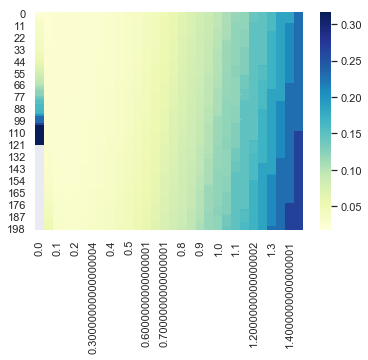

In [57]:
data = pd.DataFrame(tracking_errors)
print(data.shape)
data.columns = lam_2s
data.index = lam_1s
ax = sns.heatmap(data,cmap="YlGnBu")

(200, 30)


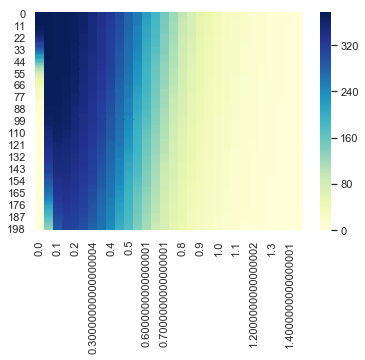

In [55]:
data = pd.DataFrame(selection_numbbers)
print(data.shape)
data.columns = lam_2s
data.index = lam_1s
ax = sns.heatmap(data,cmap="YlGnBu")